In [1]:
%matplotlib notebook
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sb

organ = 'brain-tumor'
task = 'task02'
numOfSegs = 3
organs = ['brain-growth', 'brain-tumor', 'kidney', 'prostate']
mapOrgans = ['BRGR', 'BRTU', 'KD', 'PR']
numOfTasks = [1, 3, 1, 2]
numOfValIms = [5, 4, 4, 7]
numOfSegs = [7, 3, 3, 6]
val_pth = 'Data/validation_data_v2/{}/Validation'
pred_pth = 'Validation/Results'

def load_image(pth):
    return np.squeeze(sitk.GetArrayFromImage(sitk.ReadImage(pth)))

def dice(result, reference):
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
    intersection = np.count_nonzero(result & reference)
    size_i1 = np.count_nonzero(result)
    size_i2 = np.count_nonzero(reference)

    try:
        dc = 2. * intersection / float(size_i1 + size_i2)
    except ZeroDivisionError:
        dc = 1.0
    return dc

def total_dice(ground_truth, predicted):
    prob_threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    tmp = 0
    for idx, th in enumerate(prob_threshold):
        predicted_thr = (predicted > th).astype(np.uint8)
        ground_truth_thr = (ground_truth > th).astype(np.uint8)
        tmp += dice(predicted_thr, ground_truth_thr)
    return tmp/9.0

def plot_results(data, organ, case, task):
    fig, axs = plt.subplots(1, 3)
    #fig.suptitle(' '.join((organ, case, task)) + '\ndice: {:.4f}'.format(data[organ][case][task]['dice_score']))
    src_im = data[organ][case][task]['image']
    if len(src_im.shape) == 3:
        src_im = src_im[0,:,:]
    im = axs[0].imshow(src_im, cmap='gray')
    val = axs[1].imshow(data[organ][case][task]['val_mask'], cmap='gray')
    pred = axs[2].imshow(data[organ][case][task]['pred_mask'], cmap='gray')
    axs[0].set_title('Image dice: {:.4f}'.format(data[organ][case][task]['dice_score']))
    axs[1].set_title('Validation mask')
    axs[2].set_title('Prediction mask')
    fig.colorbar(val, ax=axs[1], fraction=0.04)
    fig.colorbar(pred, ax=axs[2], fraction=0.04)
    plt.tight_layout()

In [15]:
data = {}
data_dice = {}

for idx, organ in enumerate(organs):
    data[organ] = {}
    data_dice[organ] = {}
    for case in os.listdir(os.path.join(pred_pth, organ)):
        data[organ][case] = {}
        data_dice[organ][case] = {}
        for task in range(numOfTasks[idx]):
            data[organ][case]['task0'+str(task+1)] = {}
            data_dice[organ][case]['task0'+str(task+1)] = {}

for idx, organ in enumerate(organs):
    for task in range(numOfTasks[idx]):
        for case in os.listdir(os.path.join(pred_pth, organ)):
            val_mask = []
            pred_mask = []
            for i in range(numOfSegs[idx]):
                val_mask.append(load_image(os.path.join(val_pth.format(organ), case, 'task0' + str(task+1) + '_seg0'+ str(i+1) + '.nii.gz')))
            val_mask = np.array(val_mask).sum(axis=0)/numOfSegs[idx]
            pred_mask = load_image(os.path.join(pred_pth, organ, case, 'task0'+str(task+1) +'.nii.gz'))
            src_im = load_image(os.path.join(val_pth.format(organ), case, 'image.nii.gz'))
            data[organ][case]['task0'+str(task+1)]['image'] = src_im
            data[organ][case]['task0'+str(task+1)]['val_mask'] = val_mask
            data[organ][case]['task0'+str(task+1)]['pred_mask'] = pred_mask
            data[organ][case]['task0'+str(task+1)]['dice_score'] = total_dice(val_mask, pred_mask)
            data_dice[organ][case]['task0'+str(task+1)]['dice'] = total_dice(val_mask, pred_mask)
            data_dice[organ][case]['task0'+str(task+1)]['val_size'] = (val_mask>0).sum()
            data_dice[organ][case]['task0'+str(task+1)]['pred_size'] = (pred_mask>0).sum()

data_dice_analysis = {}
for idx, organ in enumerate(organs):
    data_dice_analysis[organ] = {}
    for task in range(numOfTasks[idx]):
        data_dice_analysis[organ]['task0'+str(task+1)] = {}
        dices = []
        val_sizes = []
        pred_sizes = []
        for case in data_dice[organ]:
            dices.append(data_dice[organ][case]['task0'+str(task+1)]['dice'])
            val_sizes.append(data_dice[organ][case]['task0'+str(task+1)]['val_size'])
            pred_sizes.append(data_dice[organ][case]['task0'+str(task+1)]['pred_size'])
        dices = np.array(dices)
        val_sizes = np.array(val_sizes)
        pred_sizes = np.array(pred_sizes)
        data_dice_analysis[organ]['task0'+str(task+1)]['dices'] = dices
        data_dice_analysis[organ]['task0'+str(task+1)]['val_size'] = val_sizes
        data_dice_analysis[organ]['task0'+str(task+1)]['pred_sizes'] = pred_sizes

In [16]:
data_dice_analysis

{'brain-growth': {'task01': {'dices': array([0.90572997, 0.92956909, 0.92823788, 0.93868004, 0.92865405]),
   'val_size': array([ 8188,  5571,  5048,  7234, 10602]),
   'pred_sizes': array([ 8776,  5787,  5146,  7307, 10031])}},
 'brain-tumor': {'task01': {'dices': array([0.91575541, 0.97839222, 0.92424725, 0.95258542]),
   'val_size': array([2164, 2027, 2137, 2637]),
   'pred_sizes': array([1961, 2072, 1714, 2578])},
  'task02': {'dices': array([0.46369485, 0.63256847, 0.94136044, 0.98837122]),
   'val_size': array([1857, 1955, 1744, 2295]),
   'pred_sizes': array([1734, 1905, 1645, 2148])},
  'task03': {'dices': array([0.53352441, 0.90878307, 0.84187914, 0.66666667]),
   'val_size': array([ 51,  41, 735,   0]),
   'pred_sizes': array([ 89,  46, 539,   3])}},
 'kidney': {'task01': {'dices': array([0.9824884 , 0.97314293, 0.97122952, 0.96913088]),
   'val_size': array([5407, 5024, 4772, 4978]),
   'pred_sizes': array([5383, 5262, 4874, 4994])}},
 'prostate': {'task01': {'dices': array(

In [4]:
#plot_results(data, 'brain-tumor', 'case32', 'task02')

<IPython.core.display.Javascript object>


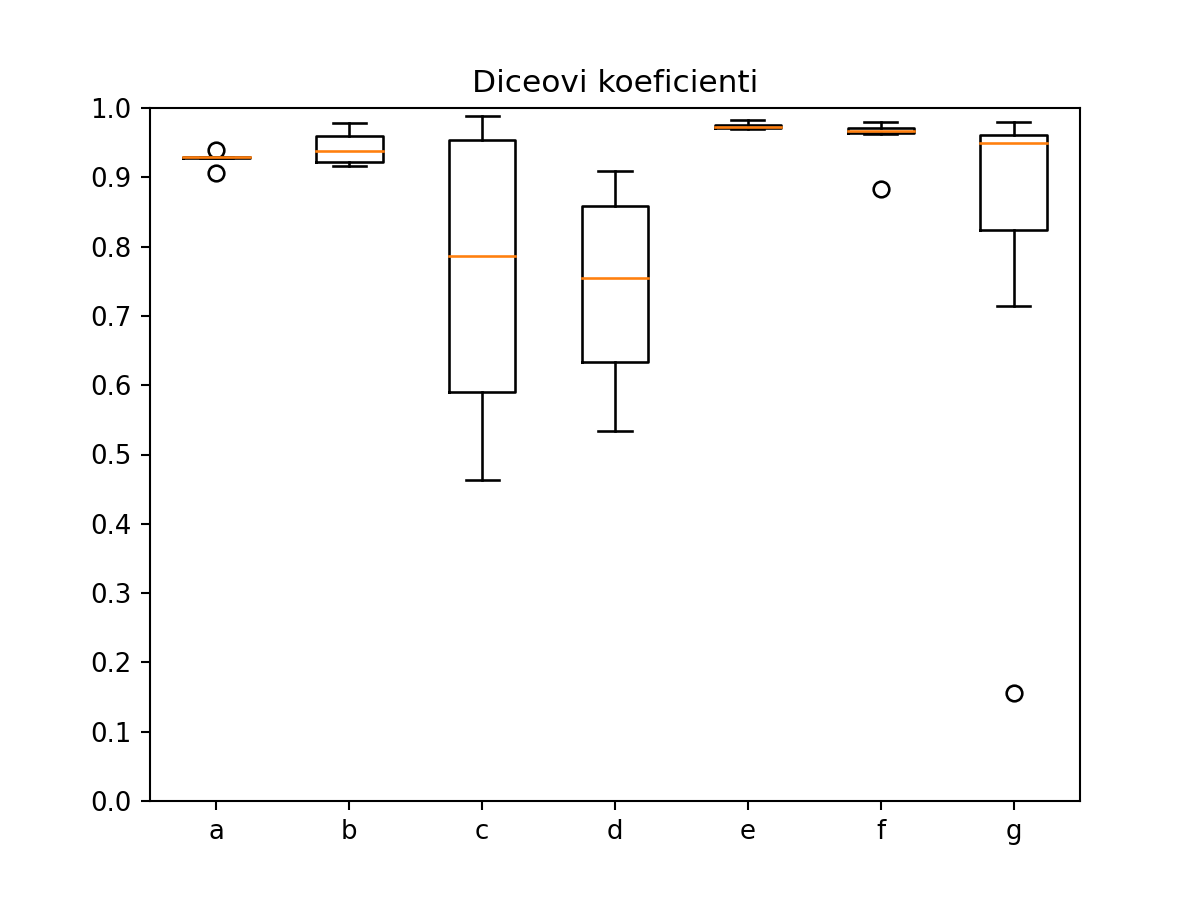

In [20]:
dcs = []
means = []
stds = []
val_sizes = []
pred_sizes = []
for i in range(4):
    organ = organs[i]
    for task in data_dice_analysis[organ]:
        tmp = data_dice_analysis[organ][task]['dices']
        means.append(tmp.mean())
        stds.append(tmp.std())
        dcs.append(tmp)

labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g']

plt.figure()
plt.boxplot(dcs, labels=labels)
plt.ylim([0.0, 1.0])
plt.yticks(np.arange(0,1.1,0.1))
plt.title('Diceovi koeficienti')
plt.show()

